# Final Project: New York vs. The U.S.

Students: Michael Hernandez and Tim Lynch <br>
Professor: Charles Pak<br>

For the final project we are utilizing Beautiful Soup and read_csv() to pull in data from two different sources (The CDC and Data.gov). We will be comparing New York deaths to other states. 

In [1]:
import pandas as pd
import requests
import numpy as np
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
%matplotlib inline

#The CSV data is found at https://catalog.data.gov *For full link refer to discussion post*
csv_data = pd.read_csv('csv_data.csv')

# For the HTML Data we used BeautifulSoup to pull the data
res = requests.get("https://www.cdc.gov/nchs/pressroom/states/newyork/newyork.htm")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')
# this builds a list of tables
df = pd.read_html(str(table))

# The final row in the table is not data I want (it's a subtitle), so I'll loop through the tables and delete that row
# Some extra cleanup - eliminated the numeric indexes from the labels using regex

for dataframe in df:
    dataframe.drop(dataframe.tail(1).index,inplace=True)
    dataframe.iloc[:,0] = dataframe.iloc[:,0].str.replace('\d+\.', '')
    dataframe.rename(columns={ dataframe.columns[0]: "Cause Name", dataframe.columns[2]: "Rate" }, inplace=True)
    

# Next I want to create the data frames from the list of data frames we created.  
# I'll pull the data using their index locations, we'll add in the Year column

frames = [df[1], df[5], df[9], df[13]]

# To make it clearer/easier to verify data, I'm building out descriptive dataframe names:

ny_death_data_2017 = frames[0]
ny_death_data_2016 = frames[1]
ny_death_data_2015 = frames[2]
ny_death_data_2014 = frames[3]


## We will start our analysis with the csv data

In [2]:
csv_data.head(5)

,Year,113 Cause Name,Cause Name,State,Deaths,Age-adjusted Death Rate
0,2012,"Nephritis, nephrotic syndrome and nephrosis (N...",Kidney disease,Vermont,21,2.6
1,2016,"Nephritis, nephrotic syndrome and nephrosis (N...",Kidney disease,Vermont,30,3.7
2,2013,"Nephritis, nephrotic syndrome and nephrosis (N...",Kidney disease,Vermont,30,3.8
3,2000,"Intentional self-harm (suicide) (*U03,X60-X84,...",Suicide,District of Columbia,23,3.8
4,2014,"Nephritis, nephrotic syndrome and nephrosis (N...",Kidney disease,Arizona,325,4.1


__For the most part we aren't interested in a few of these columns in the csv dataset. At least not yet. So we will be cleaning up the data.__

We will start by dropping a few of the columns. Mainly the "113 Cause Name" and "Age-adjusted Death Rate"

In [3]:
csv_data.drop(['113 Cause Name', 'Age-adjusted Death Rate'], axis = 1, inplace = True)

Next we'll create two dataframes, one with aggregate death data, and the other with suicide data.  We'll also add another dataframe that analyzes aggregate and suicide data in New York - this will be useful for intra-data comparisons later on.

In [4]:
agg_data = csv_data[csv_data['Cause Name'].str.contains("All causes")]
suc_data = csv_data[csv_data['Cause Name'].str.contains('Suicide')]

In [5]:
agg_data.head(5)

,Year,Cause Name,State,Deaths
9360,2016,All causes,Hawaii,10913
9361,2011,All causes,Hawaii,9923
9362,2012,All causes,Hawaii,10274
9363,2015,All causes,Hawaii,11053
9364,2014,All causes,Hawaii,10767


In [6]:
suc_ny_data = suc_data[suc_data['State'].str.contains("New York")]

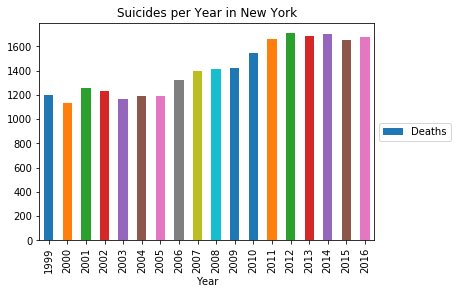

In [7]:
f = plt.figure()
plt.title('Suicides per Year in New York', color='black')
suc_ny_data.sort_values(by=['Year']).plot(kind='bar', x="Year", y="Deaths", ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

__Suicides in New York have been increasing steadily since the early 2000s__

## The HTML dataset 

In [8]:
ny_death_data_2017.head(5)

,Cause Name,Deaths,Rate,State Rank*,U.S. Rate**
0,Heart Disease,44092,171.2,17th,165.0
1,Cancer,34956,141.2,41st,152.5
2,Accidents,7687,35.5,49th,49.4
3,Chronic Lower Respiratory Diseases,7258,28.9,48th,40.9
4,Stroke,6264,24.6,50th,37.6


I'd like to remove the cells that do not match the CSV data, so let's drop them from all of our dataframes:

In [9]:
for df in frames:
    df.drop(['Rate', 'State Rank*', 'U.S. Rate**'], axis=1, inplace=True)
ny_death_data_2017.head(5)

,Cause Name,Deaths
0,Heart Disease,44092
1,Cancer,34956
2,Accidents,7687
3,Chronic Lower Respiratory Diseases,7258
4,Stroke,6264


In order to perform any graphing/comparisons of data, we need our data to be numeric type - running a .dtype on our Deaths column, I found that the data type was an object.  Here I convert the data type to numeric so we can use that death data later on.

In [10]:
for df in frames:
    df["Deaths"] = pd.to_numeric(df["Deaths"])
ny_death_data_2015['Deaths'].dtype

dtype('int64')

In [11]:
frames[0]['Year'] = 2017
frames[1]['Year'] = 2016
frames[2]['Year'] = 2015
frames[3]['Year'] = 2014
ny_death_data_2017.head(5)

,Cause Name,Deaths,Year
0,Heart Disease,44092,2017
1,Cancer,34956,2017
2,Accidents,7687,2017
3,Chronic Lower Respiratory Diseases,7258,2017
4,Stroke,6264,2017


In [12]:
for df in frames:
    df['Cause Name'] = df['Cause Name'].str.replace('Chronic Lower Respiratory Diseases', 'Chronic Lower Respiratory Disease')
ny_death_data_2017.head(5)

,Cause Name,Deaths,Year
0,Heart Disease,44092,2017
1,Cancer,34956,2017
2,Accidents,7687,2017
3,Chronic Lower Respiratory Disease,7258,2017
4,Stroke,6264,2017


Now that our data is free of type problems and is in the proper format, I'll combine the list of dataframes into one dataframe with wide data.

In [13]:
result = pd.concat(frames)
result.head(5)

,Cause Name,Deaths,Year
0,Heart Disease,44092,2017
1,Cancer,34956,2017
2,Accidents,7687,2017
3,Chronic Lower Respiratory Disease,7258,2017
4,Stroke,6264,2017


Let's do some data exploration - first I'll look to compare all death types by year, we'll do a pivot table to get a list of deaths per year so we can graph out the top 10 causes of death by year.

In [14]:
graph_data = result.pivot(index='Year', columns='Cause Name', values='Deaths')
graph_data

Cause Name,Accidents,Alzheimer’s disease,Cancer,Chronic Lower Respiratory Disease,Diabetes,Flu/Pneumonia,Heart Disease,Hypertension,Kidney Disease,Septicemia,Stroke
Year,,,,,,,,,,,
2014,5945.0,2639.0,35392.0,6806.0,4064.0,4702.0,43116.0,NaN,2207.0,2568.0,6212.0
2015,6515.0,3174.0,35089.0,7109.0,4045.0,4881.0,44450.0,2287.0,NaN,2601.0,6292.0
2016,7354.0,3349.0,35368.0,6860.0,4038.0,4513.0,44076.0,2468.0,NaN,2545.0,6258.0
2017,7687.0,3521.0,34956.0,7258.0,4176.0,4517.0,44092.0,2699.0,NaN,2296.0,6264.0


And we will plot out that data using Matplotlib

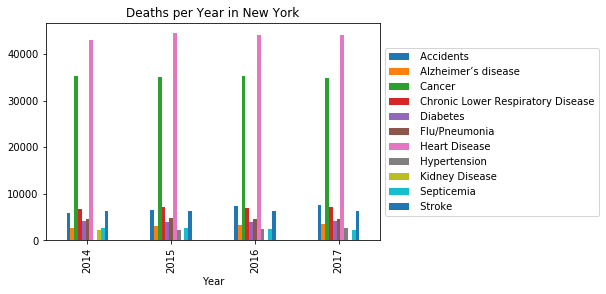

In [15]:
f = plt.figure()
plt.title('Deaths per Year in New York', color='black')
graph_data.plot(kind='bar', ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

That's a big confusing graph, with too much data to reliably read.  Let's limit the data to the top three causes of death per year only.  

In [16]:
top3_deaths = result.groupby('Year').head(3).pivot(index='Year', columns='Cause Name', values='Deaths')
top3_deaths

Cause Name,Accidents,Cancer,Chronic Lower Respiratory Disease,Heart Disease
Year,,,,
2014,NaN,35392.0,6806.0,43116.0
2015,NaN,35089.0,7109.0,44450.0
2016,7354.0,35368.0,NaN,44076.0
2017,7687.0,34956.0,NaN,44092.0


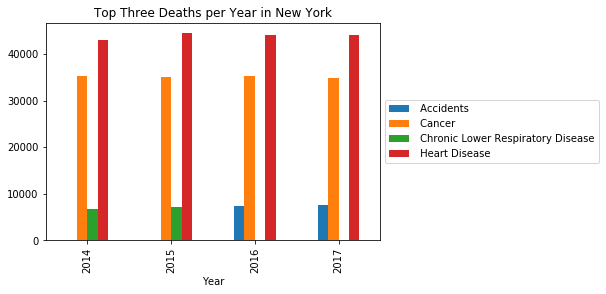

In [17]:
f = plt.figure()
plt.title('Top Three Deaths per Year in New York', color='black')
top3_deaths.plot(kind='bar', ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

__We can see in this graph that Chronic Lower Respiratory Disease was overtaken by accidents after 2015, possibly due to the population in New York smoking less since the smoking ban.__ 

To demonstrate data comparisons between the two data sets, let's combine data sets.  The csv data set has data from 2000 to 2016, the HTML data has data from 2014 to 2016.  To perform a comparison, we'll need to slice a subset of each dataset which match for the intersecting years.

Suicide is not in the top 10 causes of death in New York, let's see what the difference is for the 10th highest cause of death and suicide.

In [18]:
data = suc_ny_data.sort_values(by=['Year']).tail(3)
data.drop(['State', 'Cause Name'], axis = 1, inplace = True)
data.rename(columns={ data.columns[1]: "Suicide"}, inplace=True)
data

,Year,Suicide
187,2014,1700
157,2015,1652
186,2016,1679


In [26]:
low_10_deaths = result.groupby('Year').tail(1).pivot(index='Year', columns='Cause Name', values='Deaths')
all_data = pd.merge(data, low_10_deaths, 'left', on = ["Year"] )
all_data.set_index(['Year'], inplace=True)
all_data.tail(3)

,Suicide,Hypertension,Kidney Disease,Septicemia
Year,,,,
2014,1700,NaN,2207.0,NaN
2015,1652,2287.0,NaN,NaN
2016,1679,2468.0,NaN,NaN


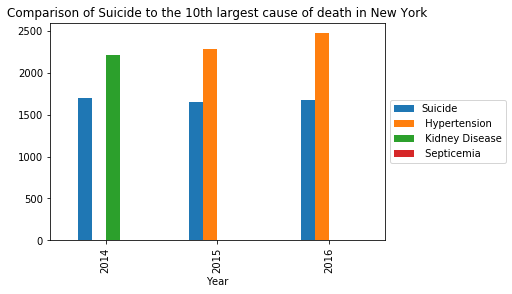

In [28]:
f = plt.figure()
plt.title('Comparison of Suicide to the 10th largest cause of death in New York', color='black')
all_data.plot(kind='bar', ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [21]:
suc_data = data.copy()
suc_data['Cause Name'] = 'Suicide'
suc_data.rename(columns={ data.columns[1]: "Deaths"}, inplace=True)
suc_data.reset_index()
frames = [result, suc_data]
dd = pd.concat(frames, sort=False)
dd2016 = dd[dd['Year'] == 2016]
dd2016

,Cause Name,Deaths,Year
0,Heart Disease,44076,2016
1,Cancer,35368,2016
2,Accidents,7354,2016
3,Chronic Lower Respiratory Disease,6860,2016
4,Stroke,6258,2016
5,Flu/Pneumonia,4513,2016
6,Diabetes,4038,2016
7,Alzheimer’s disease,3349,2016
8,Septicemia,2545,2016
9,Hypertension,2468,2016


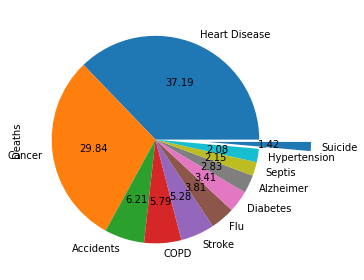

In [22]:
labels = ['Heart Disease', 'Cancer','Accidents','COPD','Stroke','Flu','Diabetes','Alzheimer','Septis','Hypertension','Suicide']
dd2016.plot(kind='pie', y='Deaths', autopct='%.2f', fontsize=10, labels=labels, explode=(0,0,0,0,0,0,0,0,0,0,0.5), legend=False)
plt.tight_layout()
plt.show()

At %1.42 of the total deaths for 2016, Suicide is a small fraction of the total death rate in New York.  